In this file, X is Topelitz corelated. We show the slope of $log(|\beta_t-\beta^*|_1)$ - $log(t)$, the Empirical Convergence for different online rounds $t$, and Empirical Convergence for different initial batch size $t_0$.

In [1]:
import numpy as np
import sklearn.metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
import math
import scipy
import matplotlib.pyplot as plt

In [2]:
def MSE(x1,x2):
    return np.sum((x1-x2)**2)
def L1_error(x1,x2):
        return np.sum(abs(x1-x2))

In [3]:
np.random.seed(1)

p = 1000
T = 10000
t0= [50,100,150,200,250,300,400,500]

Cov = np.zeros((p,p))
rho = 0.5
for i in range(p):
    for j in range(p):
        Cov[i,j] = rho**abs(i-j)
    Cov[i,i]= 1
sigma = 1
Cov = Cov*sigma
eigs,_ = np.linalg.eig(Cov)
print('The minimum eig value is %f'%np.min(eigs))
mu = np.zeros(p)

The minimum eig value is 0.333334


In [4]:
theta_true = 0.5*scipy.sparse.random(p, 1, density=0.02,random_state=np.random.default_rng()).A.reshape(p)

X0_data = np.random.multivariate_normal(mu,Cov,500).T
y0_data = X0_data.T.dot(theta_true) + np.random.normal(0,1,500)


X_data = np.random.multivariate_normal(mu,Cov,T).T
y_data = X_data.T.dot(theta_true) + np.random.normal(0,1,T)

theta_init = np.random.normal(0, 0.5, p)

eta=0.001
K=20

In [5]:
def Lasso_SSR(t0,XX0,XY0,XX,XY,theta,num,step,epsilon=1e-7):
    grad_now=(XX@theta-XY)/num
    grad_init=(XX0@theta-XY0)/t0
    phi=grad_now -grad_init
    lam=math.sqrt(math.log(p)/num)
    loss=0xFFFF
    while loss>=epsilon:
        theta_p=theta
        tmp=theta-step*((XX0@theta-XY0)/t0+phi).T
        theta=np.sign(tmp)*np.maximum(abs(tmp)-lam*step,0)
        loss=np.sum((theta-theta_p)**2)
    return theta

In [6]:
def Lasso_IHT(XX,XY,num,theta,idx,eta): 
    theta  = theta  - eta*(XX@theta - XY)/num
    temp = np.zeros(p)
    temp[idx] = theta[idx]  
    return temp

In [7]:
def test_slope(S,t0):
    error_SSR,error_OS,error_OSK=[],[],[]
    X0=X0_data[:,0:t0+1]
    y0=y0_data[0:t0+1]
    XX0=X0@X0.T
    XY0=X0@y0
    XX=np.zeros((p,p))
    XY=np.zeros(p)
    init_m = LassoCV(cv=5, fit_intercept = False, random_state=0).fit(X0.T, y0)
    theta_LASSO= init_m.coef_
    theta_OS= init_m.coef_
    theta_OSK= init_m.coef_
    idx_LASSO = np.nonzero(init_m.coef_)[0]
    a,b=np.linalg.eig(XX0)
    step=0.05*t0/np.max(a.real)
    for i in range(T):
        num=i+1
        x=X_data[:,i]
        y=y_data[i]
        XX = XX + np.outer(x,x.T)
        XY = XY + x*y
        if i >= S:
            theta_LASSO=Lasso_SSR(100,XX0,XY0,XX,XY,theta_LASSO,num,step)
        if (i+1)%(T/100)==0:
            print("progress rate: {}% ...".format((i+1)/(T/100)))
        error_SSR.append(L1_error(theta_LASSO,theta_true))
    return error_SSR

In [8]:
error_SSR=test_slope(20,500)

progress rate: 1.0% ...
progress rate: 2.0% ...
progress rate: 3.0% ...
progress rate: 4.0% ...
progress rate: 5.0% ...
progress rate: 6.0% ...
progress rate: 7.0% ...
progress rate: 8.0% ...
progress rate: 9.0% ...
progress rate: 10.0% ...
progress rate: 11.0% ...
progress rate: 12.0% ...
progress rate: 13.0% ...
progress rate: 14.0% ...
progress rate: 15.0% ...
progress rate: 16.0% ...
progress rate: 17.0% ...
progress rate: 18.0% ...
progress rate: 19.0% ...
progress rate: 20.0% ...
progress rate: 21.0% ...
progress rate: 22.0% ...
progress rate: 23.0% ...
progress rate: 24.0% ...
progress rate: 25.0% ...
progress rate: 26.0% ...
progress rate: 27.0% ...
progress rate: 28.0% ...
progress rate: 29.0% ...
progress rate: 30.0% ...
progress rate: 31.0% ...
progress rate: 32.0% ...
progress rate: 33.0% ...
progress rate: 34.0% ...
progress rate: 35.0% ...
progress rate: 36.0% ...
progress rate: 37.0% ...
progress rate: 38.0% ...
progress rate: 39.0% ...
progress rate: 40.0% ...
progress 

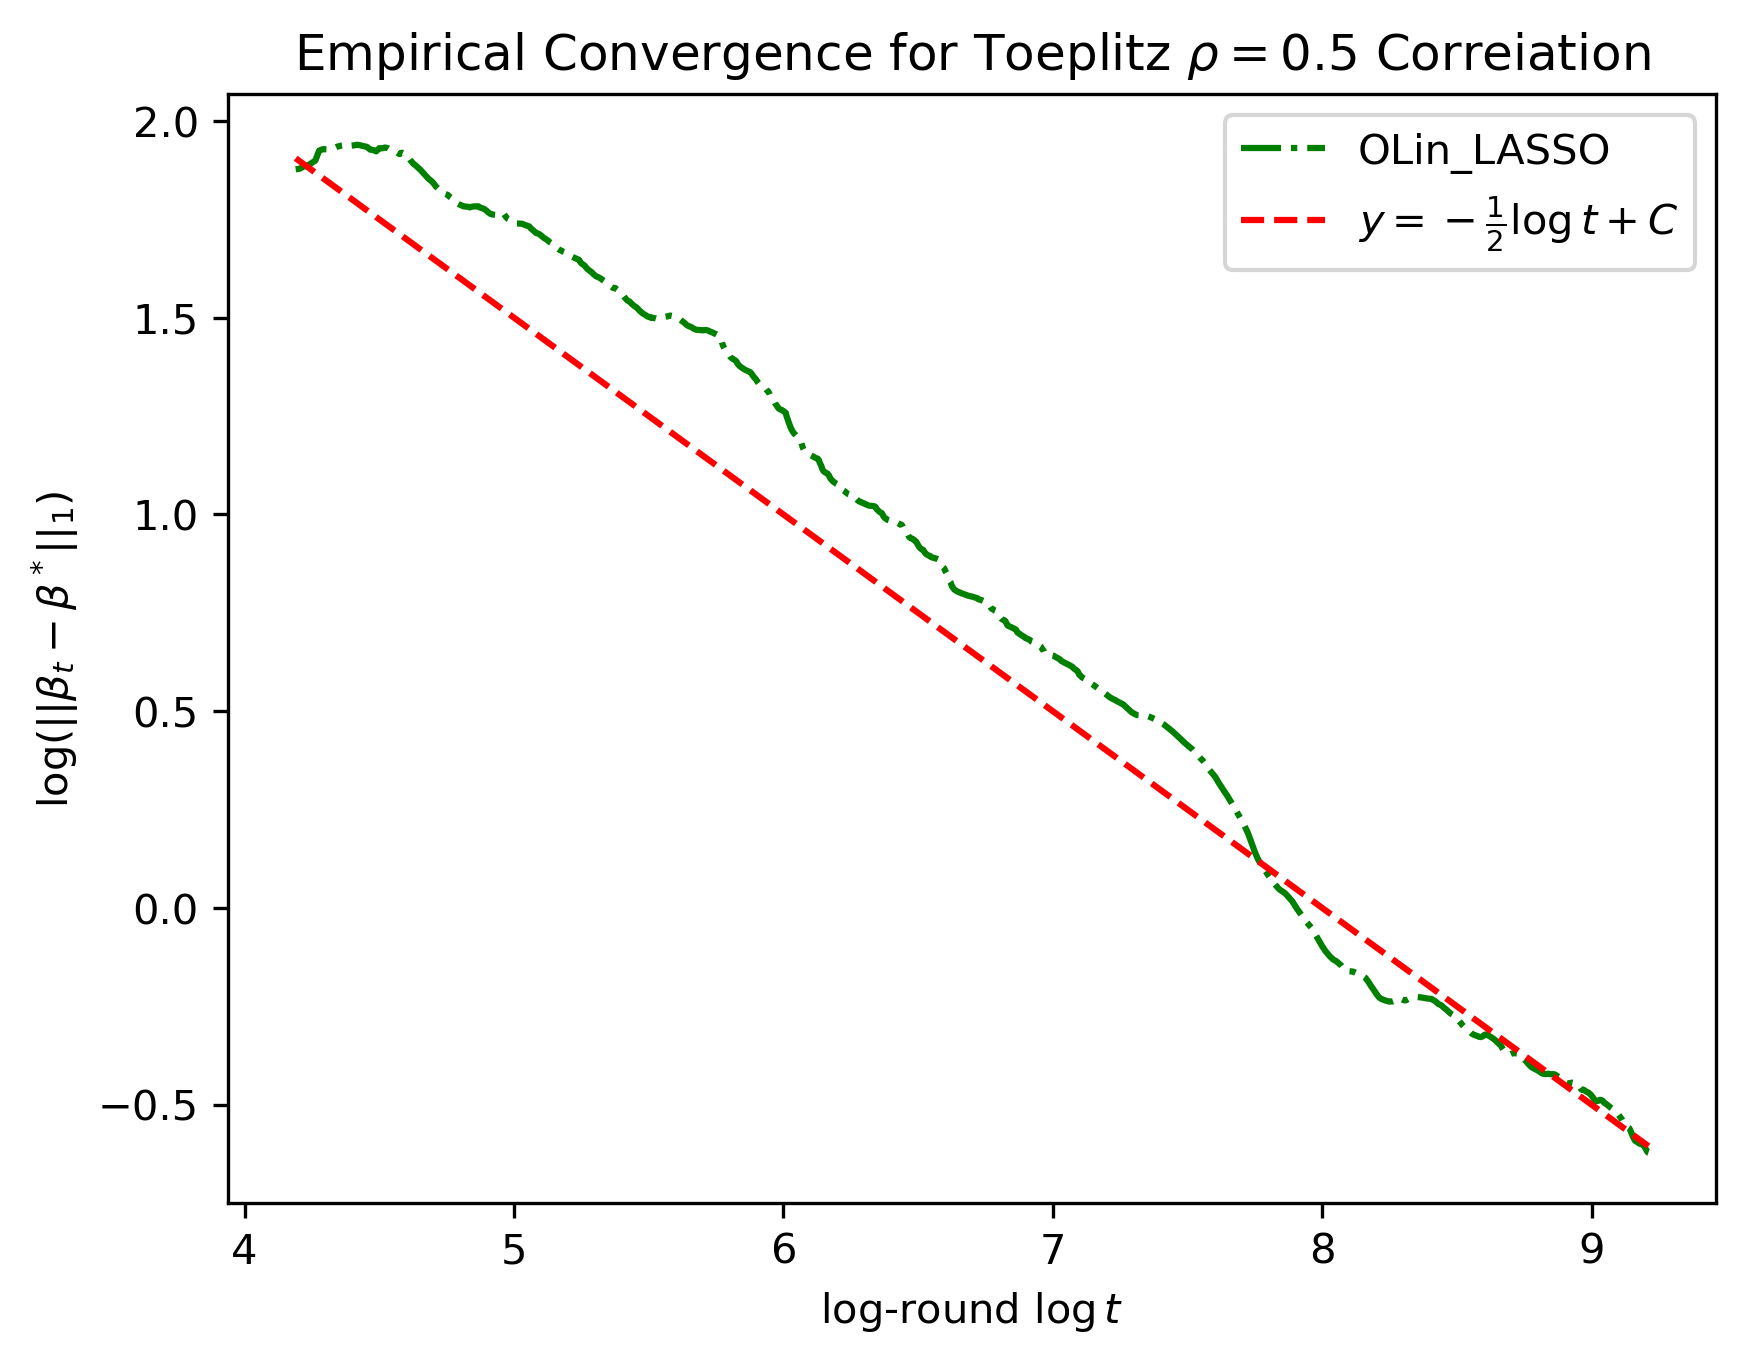

In [9]:
begin=65
plt.figure(dpi=300)
xline=np.array([math.log(i+1) for i in range(begin,T)])
tmp=[math.log(error_SSR[i]) for i in range(begin,T)]
lines=-0.5*xline+4
plt.plot(xline,tmp,label = "OLin_LASSO", linestyle="-.",color='g')
plt.plot(xline,lines,label = "$y=-\\frac{1}{2}\\log t + C$", linestyle="--",color='r')

plt.xlabel('log-round $\\log t$')
plt.ylabel('$\\log(|| \\beta_t - \\beta^*||_1)$')
plt.title("Empirical Convergence for Toeplitz $\\rho = 0.5$ Correiation")
plt.legend()
plt.show()

In [10]:
def test_data_size(S,t0):
    error_SSR,error_OS,error_OSK=[],[],[]
    stmp=[]
    X0=X0_data[:,0:t0+1]
    y0=y0_data[0:t0+1]
    XX0=X0@X0.T
    XY0=X0@y0
    XX=np.zeros((p,p))
    XY=np.zeros(p)
    init_m = LassoCV(cv=5, fit_intercept = False, random_state=0).fit(X0.T, y0)
    theta_LASSO= init_m.coef_
    theta_OS= init_m.coef_
    theta_OSK= init_m.coef_
    idx_LASSO = np.nonzero(init_m.coef_)[0]
    a,b=np.linalg.eig(XX0)
    step=0.003*t0/np.max(a.real)
    for i in range(T):
        num=i+1
        x=X_data[:,i]
        y=y_data[i]
        XX = XX + np.outer(x,x.T)
        XY = XY + x*y
        if i >= S:
            theta_LASSO=Lasso_SSR(100,XX0,XY0,XX,XY,theta_LASSO,num,step)
        theta_OS = Lasso_IHT(XX,XY,num,theta_OS,idx_LASSO,eta)
        for j in range(K):
            theta_OSK = Lasso_IHT(XX,XY,num,theta_OSK,idx_LASSO,eta)
        if (i+1)%(T/100)==0:
            print("progress rate: {}% ...".format((i+1)/(T/100)))
            error_SSR.append(theta_LASSO)
            error_OS.append(theta_OS)
            error_OSK.append(theta_OSK)
            stmp.append(XX/(i+1))
    return error_SSR,error_OS,error_OSK,stmp

In [11]:
error_SSR,error_OS,error_OSK,SCov=test_data_size(50,150)

progress rate: 1.0% ...
progress rate: 2.0% ...
progress rate: 3.0% ...
progress rate: 4.0% ...
progress rate: 5.0% ...
progress rate: 6.0% ...
progress rate: 7.0% ...
progress rate: 8.0% ...
progress rate: 9.0% ...
progress rate: 10.0% ...
progress rate: 11.0% ...
progress rate: 12.0% ...
progress rate: 13.0% ...
progress rate: 14.0% ...
progress rate: 15.0% ...
progress rate: 16.0% ...
progress rate: 17.0% ...
progress rate: 18.0% ...
progress rate: 19.0% ...
progress rate: 20.0% ...
progress rate: 21.0% ...
progress rate: 22.0% ...
progress rate: 23.0% ...
progress rate: 24.0% ...
progress rate: 25.0% ...
progress rate: 26.0% ...
progress rate: 27.0% ...
progress rate: 28.0% ...
progress rate: 29.0% ...
progress rate: 30.0% ...
progress rate: 31.0% ...
progress rate: 32.0% ...
progress rate: 33.0% ...
progress rate: 34.0% ...
progress rate: 35.0% ...
progress rate: 36.0% ...
progress rate: 37.0% ...
progress rate: 38.0% ...
progress rate: 39.0% ...
progress rate: 40.0% ...
progress 

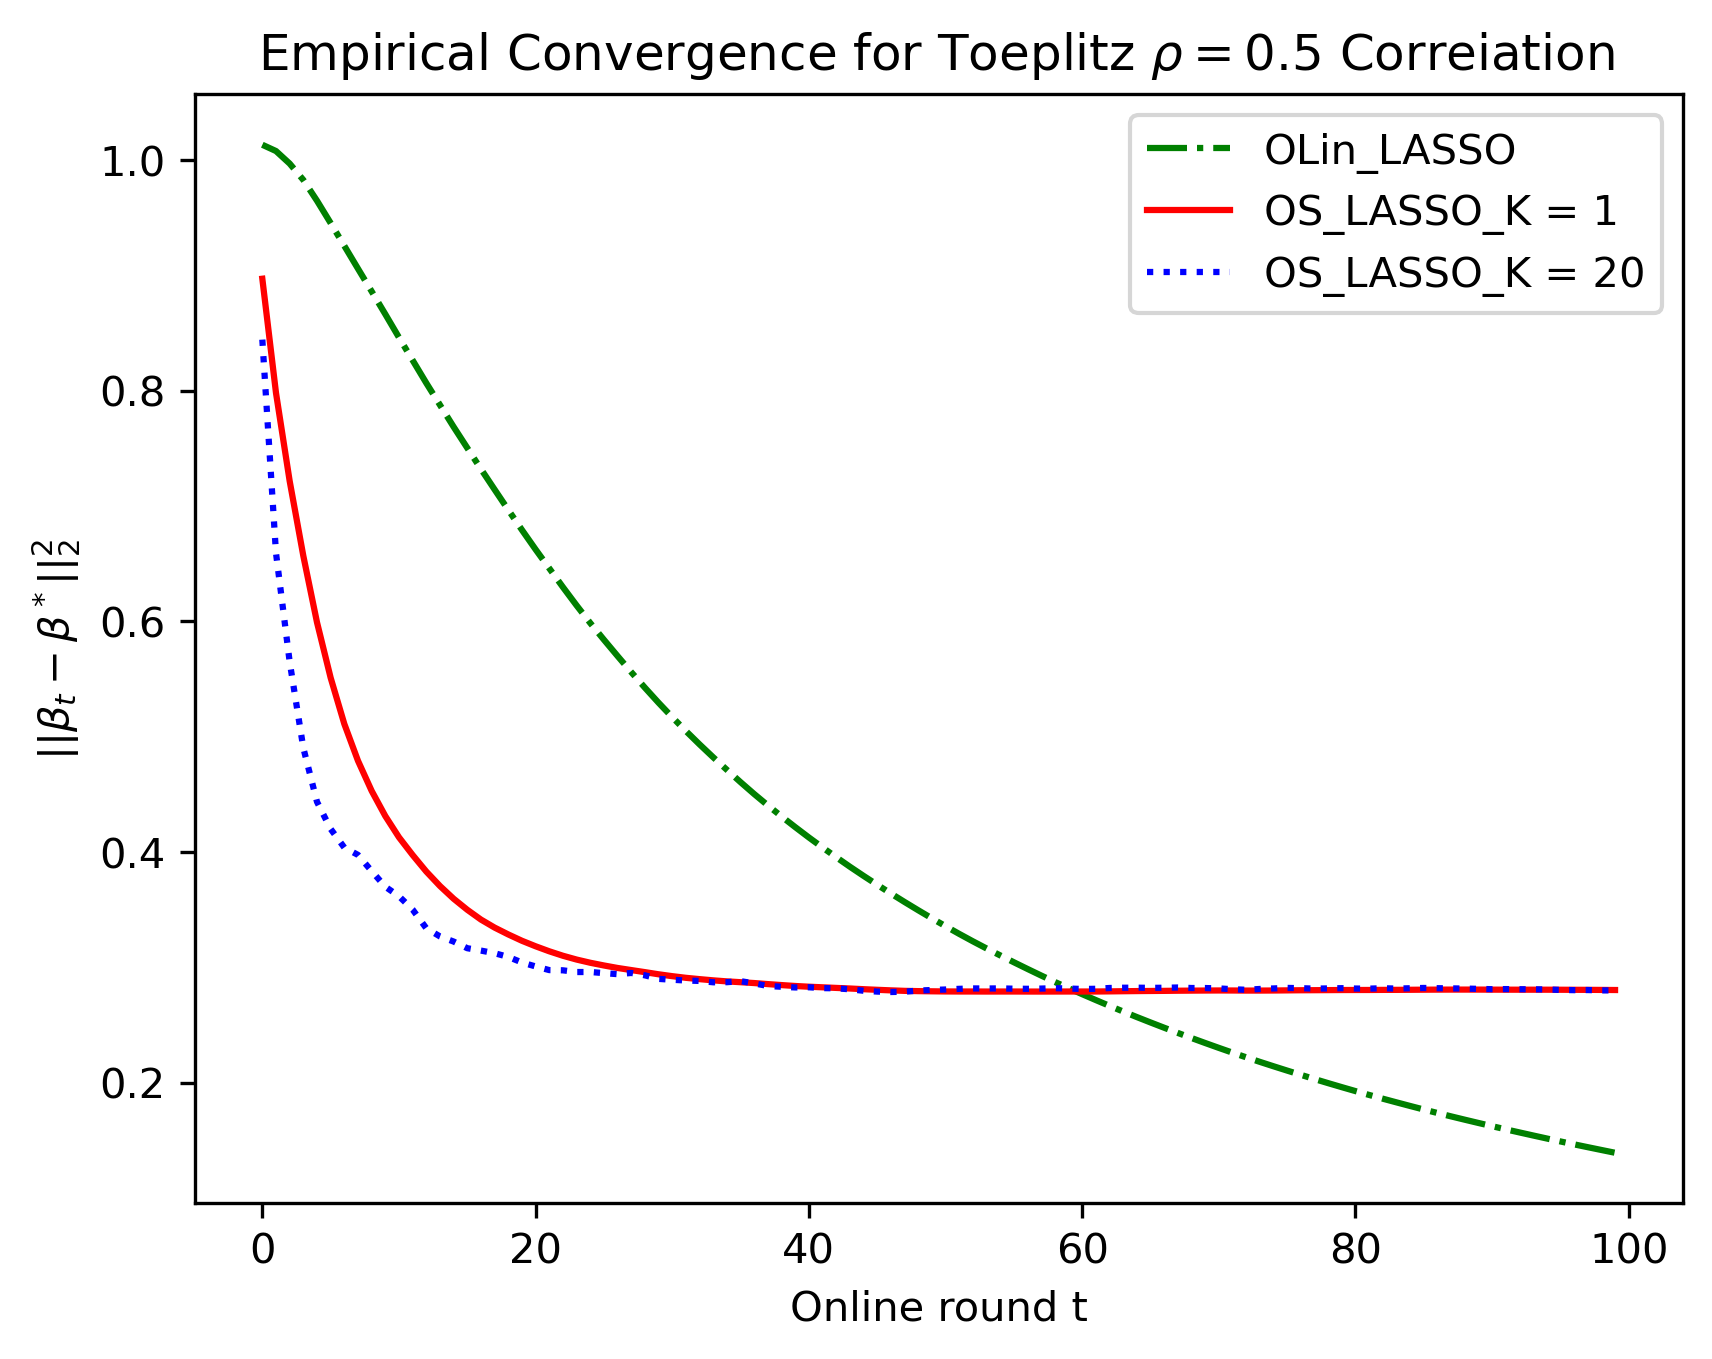

In [12]:
xline=np.array([i for i in range(len(error_SSR))])
y1line=np.array([MSE(error_SSR[i],theta_true) for i in range(len(error_SSR))])
y2line=np.array([MSE(error_OS[i],theta_true) for i in range(len(error_SSR))])
y3line=np.array([MSE(error_OSK[i],theta_true) for i in range(len(error_SSR))])
plt.figure(dpi=300)
plt.plot(xline,y1line,label = "OLin_LASSO", linestyle="-.",color='g')
plt.plot(xline,y2line,label = "OS_LASSO_K = 1", linestyle="-",color='r')
plt.plot(xline,y3line,label = "OS_LASSO_K = 20", linestyle=":",color='b')
plt.xlabel('Online round t')
plt.ylabel('$|| \\beta_t - \\beta^*||^2_2$')
#plt.ylim((0,0.5))
plt.title('Empirical Convergence for Toeplitz $\\rho = 0.5$ Correiation ')
#plt.ylim((0,0.5))
plt.legend()
plt.show()

In [13]:
def test_init_size(S,t0):
    X0=X0_data[:,0:t0+1]
    y0=y0_data[0:t0+1]
    XX0=X0@X0.T
    XY0=X0@y0
    XX=np.zeros((p,p))
    XY=np.zeros(p)
    #loss_SSR,loss_OS,loss_OSK=[],[],[]
    init_m = LassoCV(cv=5, fit_intercept = False, random_state=0).fit(X0.T, y0)
    theta_LASSO= init_m.coef_
    theta_OS= init_m.coef_
    theta_OSK= init_m.coef_
    idx_LASSO = np.nonzero(init_m.coef_)[0]
    a,b=np.linalg.eig(XX0)
    step=0.005*t0/np.max(a.real)
    for i in range(T):
        num=i+1
        x=X_data[:,i]
        y=y_data[i]
        XX = XX + np.outer(x,x.T)
        XY = XY + x*y
        if i >= S:
            theta_LASSO=Lasso_SSR(t0,XX0,XY0,XX,XY,theta_LASSO,num,step)
        theta_OS = Lasso_IHT(XX,XY,num,theta_OS,idx_LASSO,eta)
        for j in range(K):
            theta_OSK = Lasso_IHT(XX,XY,num,theta_OSK,idx_LASSO,eta)
        if (i+1)%(T/100)==0:
            print("progress rate: {}% ...".format((i+1)/(T/100)))   
    return theta_LASSO,theta_OS,theta_OSK

In [ ]:
theta_SSR,theta_OHT,theta_OHTK=[],[],[]
for j in range(len(t0)):
    theta_LASSO,theta_OS,theta_OSK=test_init_size(50,t0[j])
    theta_SSR.append(theta_LASSO)
    theta_OHT.append(theta_OS)
    theta_OHTK.append(theta_OSK)

This experiment will take a long time. So we save the experiment data in "Topelitz_01.npy" to plot the results.

In [14]:
with open('Topelitz_01.npy', 'rb') as f:
    theta_true=np.load(f)
    theta_SSR = np.load(f)
    theta_OHT = np.load(f)
    theta_OHTK = np.load(f)

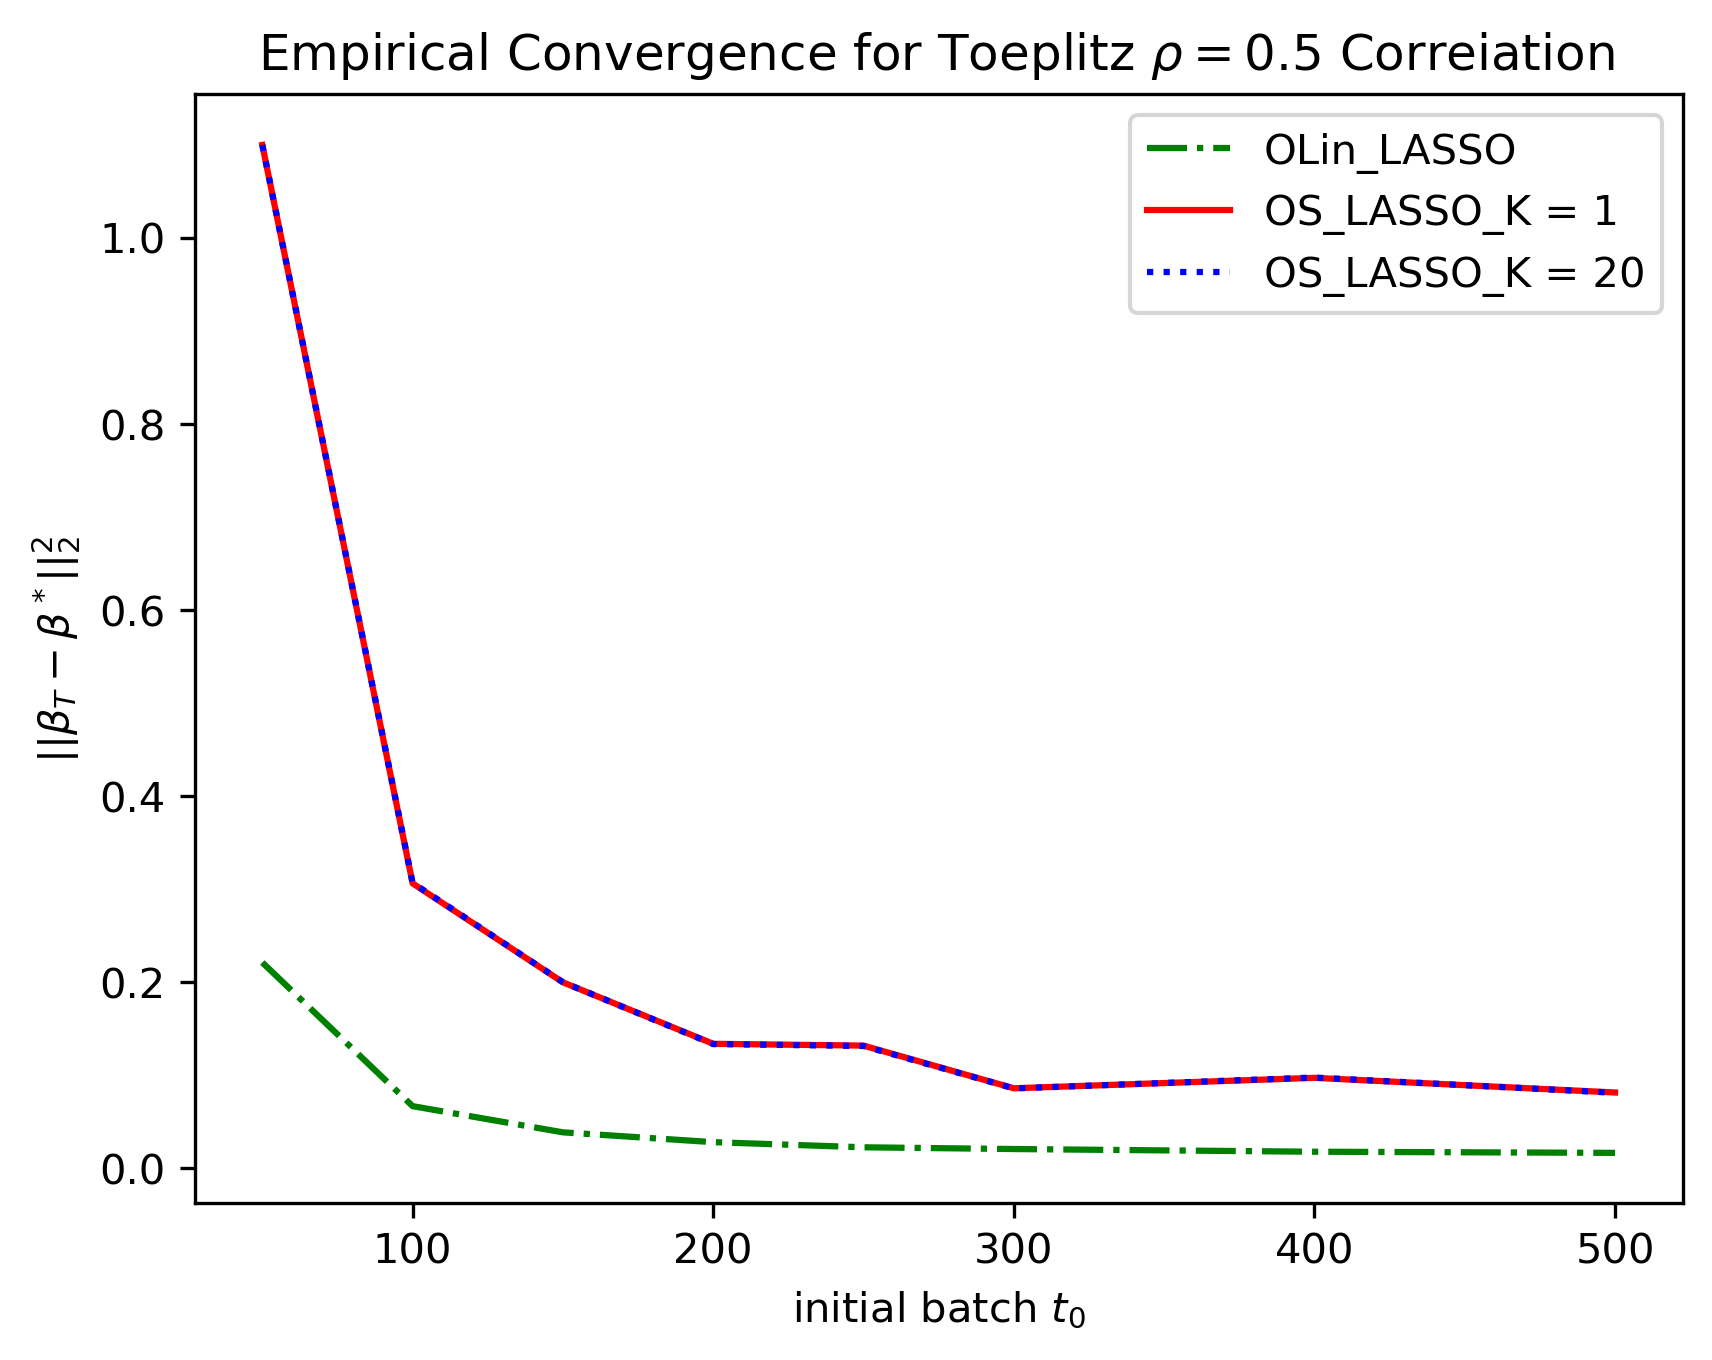

In [15]:
loss_SSR=np.array([MSE(theta_SSR[i],theta_true) for i in range(len(t0))])
loss_OS=np.array([MSE(theta_OHT[i],theta_true) for i in range(len(t0))])
loss_OSK=np.array([MSE(theta_OHTK[i],theta_true) for i in range(len(t0))])
#xline=np.array([i for i in range(T)])
plt.figure(dpi=300)
plt.plot(t0,loss_SSR,label = "OLin_LASSO", linestyle="-.",color='g')
plt.plot(t0,loss_OS,label = "OS_LASSO_K = 1", linestyle="-",color='r')
plt.plot(t0,loss_OSK,label = "OS_LASSO_K = 20", linestyle=":",color='b')
plt.xlabel('initial batch $t_0$')
plt.ylabel('$|| \\beta_T - \\beta^*||^2_2$')
plt.title('Empirical Convergence for Toeplitz $\\rho = 0.5$ Correiation ')
#plt.ylim((0,0.5))
plt.legend()

plt.show()